<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Исаков Данила Андреевич

**Забавный факт о себе:** ох...

## Общая информация

__Дата выдачи:__ 09.12.2023

__Дедлайн:__ 23:59MSK 18.12.2023

В случае этой домашки мягкий дедлан совпадает с жёстким.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5.2 балла (3 основных балла и ещё 2.2 бонусных).

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [3]:
import gdown

# здесь по советам проверенных комрадов вставляю ссылку на свой диск
url = "https://drive.google.com/drive/folders/1BJR55xIUvTJP1fWFvSfS1D3MRQ9jMFSl"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/hw4/ria_news.tsv',
 '/content/hw4/vk_comments.tsv',
 '/content/hw4/vk_news.tsv']

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [4]:
df_ria = pd.read_csv('hw4/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [106]:
df_vk = pd.read_csv('hw4/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [6]:
df_comments = pd.read_csv('hw4/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

<ipython-input-6-e18b2c7af034>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('hw4/vk_comments.tsv', sep='\t')


(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Вы обучите нейросеть предсказывать категорию новости
2. Вы построите предсказания для тех новостей, где мы ничего не знаем о категории
3. Вы используете уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Вы проведёте аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (1.2 + 2 бонусных балла)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [8]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [9]:
target_tags = {tag for tag,cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

Закодируем теги для OHE.

In [10]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item,jtem in tag2idx.items()}

Почистим таргет от лишних тэгов.

In [11]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [12]:
df_ria.target_tags.values[:3]

array([list([184, 1393, 414]), list([626, 1414, 414]), list([1493])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к маленькому регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [13]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
import re
from nltk.tokenize import word_tokenize

def normalise_text(text):
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [ ]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [15]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [16]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [ ]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [17]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNK#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.2 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [107]:
# your code here
# ヽ(♡‿♡)ノ

df_vk['title_clean'] = df_vk.title.apply(normalise_text)

In [19]:
# а теперь я решил немного адаптировать функцию с учётом пропущенных значений
def normalise_snippet(text):
    if text == '#UNK#':
      return text
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

In [108]:
df_ria['snippet'] = df_ria['snippet'].fillna('#UNK#')
df_vk['snippet'] = df_vk['snippet'].fillna('#UNK#')

In [109]:
df_ria['snippet_clean'] = df_ria.snippet.apply(normalise_snippet)
df_vk['snippet_clean'] = df_vk.snippet.apply(normalise_snippet)

In [22]:
df_ria.head(10)

,href,date,time,title,snippet,text,category,tags,shows,target_tags,title_clean,snippet_clean
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"биньямин нетаньяху,израиль,в мире",728.0,"[184, 1393, 414]",нетаньяху не собирается в отставку в случае пр...,премьерминистр израиля биньямин нетаньяху не н...
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"эммануэль макрон,франция,в мире",3086.0,"[626, 1414, 414]",макрон в новогоднем обращении затронул тему ре...,результат реформ не может быть мгновенным заяв...
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,теннис,79.0,[1493],пятая ракетка мира дель потро пропустит открыт...,аргентинский теннисист хуан мартин дель потро ...
5,/20181231/1548961218.html,2018-12-31,"31 декабря 2018, 23:06",СМИ: Кевину Спейси не разрешили отсутствовать ...,Суд в американском штате Массачусетс отверг хо...,"МОСКВА, 31 дек - РИА Новости. Суд в американск...",В мире,"кевин спейси,сша,в мире",2058.0,"[888, 414]",сми кевину спейси не разрешили отсутствовать н...,суд в американском штате массачусетс отверг хо...
6,/20181231/1548961194.html,2018-12-31,"31 декабря 2018, 23:06","""Зимняя классика"" НХЛ в 2020 году пройдет в Да...","""Зимняя классика"" - матч регулярного чемпионат...","МОСКВА, 31 дек - РИА Новости. ""Зимняя классика...",NaN,"нхл,хоккей",89.0,"[290, 965]",зимняя классика нхл в 2020 году пройдет в далл...,зимняя классика матч регулярного чемпионата н...
7,/20181231/1548961104.html,2018-12-31,"31 декабря 2018, 22:50",В Таиланде россиянин получил тяжелую черепную ...,Россиянин Борис Победоносец 1989 года рождения...,"БАНГКОК, 31 дек – РИА Новости. Россиянин Борис...",В мире,"таиланд,в мире",4427.0,"[1111, 414]",в таиланде россиянин получил тяжелую черепную ...,россиянин борис победоносец 1989 года рождения...
8,/20181231/1548961026.html,2018-12-31,"31 декабря 2018, 22:33",Медведев поздравил россиян с наступающим Новым...,Глава российского правительства Дмитрий Медвед...,"МОСКВА, 31 дек - РИА Новости. Глава российског...",Общество,"новый год—2019,дмитрий медведев,россия,общество",2309.0,"[1052, 877, 975, 526]",медведев поздравил россиян с наступающим новым...,глава российского правительства дмитрий медвед...
9,/20181231/1548960957.html,2018-12-31,"31 декабря 2018, 22:33",Путин призвал россиян в новогоднем обращении к...,Россиянам важно быть сплоченной и единой коман...,"МОСКВА, 31 дек — РИА Новости. Россиянам важно ...",NaN,"новый год—2019,новый год,владимир путин",6209.0,"[1052, 936, 1068]",путин призвал россиян в новогоднем обращении к...,россиянам важно быть сплоченной и единой коман...
10,/20181231/1548960927.html,2018-12-31,"31 декабря 2018, 22:19",В Индонезии в результате оползней погибли не м...,По меньшей мере восемь человек погибли в резул...,"МОСКВА, 31 дек - РИА Новости. По меньшей мере ...",В мире,"индонезия,в мире",418.0,"[1295, 414]",в индонезии в результате оползней погибли не м...,по меньшей мере восемь человек погибли в резул...
11,/20181231/1548960892.html,2018-12-31,"31 декабря 2018, 22:10","В аэропорту Амстердама задержали пассажира, уг...","Пассажир, угрожавший взорвать бомбу в амстерда...","МОСКВА, 31 дек - РИА Новости. Пассажир, угрожа...",В мире,"амстердам,в мире",1058.0,"[1297, 414]",в аэропорту амстердама задержали пассажира угр...,пассажир угрожавший взорвать бомбу в амстердам...


## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [23]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [24]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [ ]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

__[0.2 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [25]:
# your code here
# ♡ (´｡• ω •｡`)

df_test = df_ria[(df_ria.date >= '2018-12-01') & (df_ria.date <= '2018-12-31')]
df_val = df_ria[(df_ria.date >= '2018-10-01') & (df_ria.date <= '2018-11-30')]
df_train = df_ria[(df_ria.date >= '2018-01-01') & (df_ria.date <= '2018-09-30')]

Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [26]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[1111, 519]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[65, 414]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[17, 949]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[526]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[1544, 414]"


Напишем датасет для поставки данных в нейросеть.


In [28]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        return (self.X_title[idx, :], self.y[idx])


__[0.2 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

In [29]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)
       if snippet is not None and max_snippet_len:
        self.X_snippet = self.create_text(snippet, max_snippet_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
      try:
        return (self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx])
      except AttributeError:
        return (self.X_title[idx, :], self.y[idx])


Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [30]:
from torch import nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [ ]:
!pip3 install pytorch_lightning

In [ ]:
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

Обучим модель.

In [ ]:
!pip install wandb

In [ ]:
import wandb

wandb.login()

wandb: Currently logged in as: vchemsmisl. Use `wandb login --relogin` to force relogin


True

In [ ]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(log_model='all', project="news_classificator")

EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 3.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.906    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,██▅▆▆▅▄▄▄▄▄▅▃▂▄▃▂▄▂▁▂▃▂▂▂▂▄▂▂▃▂▂▂▁▂▂▂▂▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▂▁▁
epoch,4
train_loss,8.84887
trainer/global_step,10694
val_loss,10.71937


__[0.2 балла] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

In [ ]:
# your code here
# (￢_￢)
class SimpleClassifier_wSnippets(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, output_dim)

    def forward(self, title, snippet):
        embedded_title = self.embedding(title)
        embedded_title = embedded_title.mean(dim=1)
        embedded_snippet = self.embedding(snippet)
        embedded_snippet = embedded_snippet.mean(dim=1)
        embedded = torch.cat([embedded_title, embedded_snippet], dim=1)
        return self.fc(embedded)

In [ ]:
class TrainLightningModule_wSnippets(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title, snippet):
        result = self.model(title, snippet)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, snippet, target = train_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, snippet, target = val_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

In [ ]:
MAX_SNIPPET_LEN = 60

train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary,
                            VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM,
                            df_train.snippet_clean.values, MAX_SNIPPET_LEN)
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary,
                          VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM,
                          df_val.snippet_clean.values, MAX_SNIPPET_LEN)
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary,
                           VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM,
                           df_test.snippet_clean.values, MAX_SNIPPET_LEN)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4)

In [ ]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(log_model='all', project="news_classificator")

EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_with_snippets = SimpleClassifier_wSnippets(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module_with_snippets = TrainLightningModule_wSnippets(model_with_snippets, LR, criterion)

trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module_with_snippets, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                       | Params
---------------------------------------------------------
0 | model     | SimpleClassifier_wSnippets | 4.0 M 
1 | criterion | CrossEntropyLoss           | 0     
---------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.806    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,█▅▅▄▅▅▄▃▄▃▃▂▃▂▃▂▃▂▂▂▂▂▂▃▂▂▁▂▁▂▂▃▂▁▁▂▁▁▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▂▁▁
epoch,4
train_loss,6.26463
trainer/global_step,10694
val_loss,10.76025


In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1vXMqUWmOoGxUgdyKmT4q7TRyPbDLqZuj/preview" width="640" height="480" allow="autoplay"></iframe>

"Бьёт", конечно, громко сказано, но работает на трейне чуть лучше, а на валидации в принципе так же. Скорее всего, проблема в маленьком размере сниппета, однако пришлось сэкономить ради работы кода.

## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [ ]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.*(y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [ ]:
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary,
                           VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

for title, target in test_dataloader:
    logit = model_baseline(title)
    pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset.__len__()

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [ ]:
TRESHOLD = 0.01
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9955158829689026
Precision: 0.28934600949287415
Recall: 0.7623404264450073


In [ ]:
TRESHOLD = 0.05
y_pred = 1*(pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.99833083152771
Precision: 0.5210325121879578
Recall: 0.616555392742157


In [ ]:
TRESHOLD = 0.9
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983207583427429
Precision: 0.004881663713604212
Recall: 0.004388805013149977


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [ ]:
def get_predict(model, dataset):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())

    for title, target in dataloader:
        logit = model(title)
        pred_prob = F.softmax(logit, dim=1)

    assert pred_prob.shape[0] == dataset.__len__()
    return pred_prob, target

__[0.2 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__ *точность показывает долю правильно угаданных (true positives) среди всех предсказаний, а полнота - среди всех таргетов, то есть истинных тегов текстов. Нам важнее сравнение работы модели с реальным данными, а не со своими же предсказаниями, поэтому важнее реколл.*

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [ ]:
def get_predict(model, dataset, threshold, snippet=False):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=100)
    if not snippet:
      for title, target in dataloader:
          logit = model(title)
          pred_prob = F.softmax(logit, dim=1)
          y_pred = 1*(pred_prob > threshold)
    else:
      for title, snippet, target in dataloader:
          logit = model(title, snippet)
          pred_prob = F.softmax(logit, dim=1)
          y_pred = 1*(pred_prob > threshold)

    # assert pred_prob.shape[0] == dataset.__len__()
    return y_pred, target

In [ ]:
# your code here
# (＠_＠)

def optimize_threshold_selection(model, dataset):
    tresholds_dict = {}
    for num in range(1, 100, 5):
      num /= 100 # гениально обхожу невозможность использования флотов в рейнже
      pred, trgt = get_predict(model, dataset, num)
      recall_score = recall(trgt, pred)
      tresholds_dict[num] = recall_score

    tresholds_sort = sorted(tresholds_dict.keys(), key=lambda x: tresholds_dict[x], reverse=True)
    return tresholds_sort[0]

In [ ]:
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

threshold = optimize_threshold_selection(model_baseline, val_dataset)

In [ ]:
threshold

0.01

In [ ]:
test_ds_no_snippets = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
predict, target = get_predict(model_baseline, test_ds_no_snippets, threshold)
recall(target, predict)

0.7035699486732483

In [ ]:
test_ds_snippets = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary,
                           VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM,
                           df_test.snippet_clean.values, MAX_SNIPPET_LEN)
predict, target = get_predict(model_with_snippets, test_ds_snippets, threshold, True)
recall(target, predict)

0.5874988436698914

*К сожалению, вышло хуже. Странно. Мб, опять же, слишком короткая длина сниппетов, либо также проблема в том, что трешхолд побирался на модели без сниппетов. Либо дело в чём-то ещё.*

__[0.2 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [ ]:
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[459, 1502]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[1399, 316]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[664, 554]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[1572]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[1549, 316]"


In [ ]:
# your code here
# (❍ᴥ❍ʋ)
oob_dataset = NewsDataset(df_oob.target_tags.values, df_oob.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
predict, target = get_predict(model_baseline, test_ds_no_snippets, threshold)
print('Exact Match:', exact_match(target, predict))
print('Precision:', precision(target, predict))
print('Recall:', recall(target, predict))

Exact Match: 0.9943146109580994
Precision: 0.35463982820510864
Recall: 0.7035699486732483


*В принципе, качество особо не упало, разве что пресижн низковат.*

## 1.6 Бонусное задание

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.5 балла]__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.   

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# (⊙_⊙)

__[0.5]__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# =^･ｪ･^=

__[1 балл]__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# ٩(ˊ〇ˋ*)و


Сравните все обученные модели между собой на тестовой выборке.

In [ ]:
# your code here
# (⌐■_■)

## Часть 2: предсказание категорий (0.3 балла)

Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [ ]:
df_vk['target_tags'] = [[0]]*df_vk.shape[0]

# your code here
# (っ˘ڡ˘ς)
vk_dataset = NewsDataset(df_vk.target_tags.values, df_vk.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)
predict, target = get_predict(model_baseline, vk_dataset, threshold)

На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

In [ ]:
# Ваш код с сохранением данных

# your code here
# ¯\_(ツ)_/¯
vk_tags = pd.DataFrame(predict.transpose(0, 1))

In [ ]:
vk_tags

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1580,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1581,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Часть 3: сентимент-классификатор (0.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [ ]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели? *некий S.Smetanin*
2. Как выглядит архитектура модели? Насколько модель большая?
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК? *На коротких текстах, так что вполне адекватно.*

Установим библиотеку. 🤗🤗🤗

In [7]:
!pip3 install transformers

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [31]:
# your code here
# ʕ•ᴥ•ʔ
from transformers import pipeline

model = pipeline(model="seara/rubert-tiny2-russian-sentiment")

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [34]:
df_comments['text'].shape

(2612629,)

In [32]:
model(['раз раз', 'всё круто'])

[{'label': 'positive', 'score': 0.6744707822799683},
 {'label': 'positive', 'score': 0.9935241937637329}]

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [37]:
import json
batch_size = 5000

saved_predictions = {'Sentiment predictions': []}
for elem in range(1, df_comments['text'].shape[0] // batch_size):
  min = 0
  sentiments = model(list(df_comments['text'])[min:batch_size*elem])

  saved_predictions['Sentiment predictions'].append(sentiments)
  saved_predictions_json = json.dumps(saved_predictions)
  with open('sentiment_predictions.json', 'w') as file:
    file.write(saved_predictions_json)
  min = batch_size

KeyboardInterrupt: ignored

In [38]:
# короче, код работает, вот мой миленький джейсончик:
with open('sentiment_predictions.json', 'r') as file:
    json_dict = file.read()
json_dict

'{"Sentiment predictions": [[{"label": "neutral", "score": 0.9122462868690491}, {"label": "neutral", "score": 0.8793703317642212}, {"label": "positive", "score": 0.6762612462043762}, {"label": "neutral", "score": 0.9259392023086548}, {"label": "neutral", "score": 0.8662225008010864}, {"label": "neutral", "score": 0.8428512215614319}, {"label": "neutral", "score": 0.924575924873352}, {"label": "neutral", "score": 0.9119594693183899}, {"label": "neutral", "score": 0.7873875498771667}, {"label": "neutral", "score": 0.88370281457901}, {"label": "neutral", "score": 0.8923456072807312}, {"label": "neutral", "score": 0.8507293462753296}, {"label": "neutral", "score": 0.8434337377548218}, {"label": "neutral", "score": 0.5309107303619385}, {"label": "negative", "score": 0.7910670638084412}, {"label": "neutral", "score": 0.7685768604278564}, {"label": "negative", "score": 0.5791844129562378}, {"label": "negative", "score": 0.8996487855911255}, {"label": "neutral", "score": 0.8236954808235168}, {

In [41]:
# скачаю-ка я готовые данные у дорогих коллег...
emotes_url = "https://drive.google.com/drive/folders/1wg-jbzA38BFjh-F81M5QOWR6_HA2Wx3V?usp=sharing"
gdown.download_folder(emotes_url, quiet=True, use_cookies=False)

['/content/out/out.csv']

In [44]:
emotes = pd.read_csv('/content/out/out.csv')
emotes

,label,score
0,neutral,0.912246
1,neutral,0.879370
2,positive,0.676261
3,neutral,0.925939
4,neutral,0.866223
...,...,...
2612624,neutral,0.649754
2612625,negative,0.697936
2612626,negative,0.623313
2612627,neutral,0.873600


In [45]:
df_comments['sentiment_verdict'] = emotes['label']
df_comments['sentiment_score'] = emotes['score']

# <ваш код для сохранения данных>

# your code here
# ¯\_(ツ)_/¯

# P.S. Код для скоринга комментариев работает довольно долго. Первый, кто проскорит всю базу, может поделиться ей в общем чате с однокурсниками
# Если вы используете эту базу, просто продемонстрируйте при решении этого пункта, что ваш код работает
df_comments.head()

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223


## Часть 4: аналитика (1 балл + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.2 балла]__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [46]:
# your code here
# ʕ•ᴥ•ʔ
rate_positive = df_comments[df_comments['sentiment_verdict'] == 'positive'].shape[0] / df_comments.shape[0]
rate_negative = df_comments[df_comments['sentiment_verdict'] == 'negative'].shape[0] / df_comments.shape[0]

print(f'Доля позитивных комментов: {rate_positive}')
print(f'Доля негативных комментов: {rate_negative}')

Доля позитивных комментов: 0.06954603964053067
Доля негативных комментов: 0.2209980827740946


In [53]:
df_comments[df_comments['sentiment_verdict'] == 'positive'].sort_values('sentiment_score', ascending=False)[:10]['text'].values

array(['По всем рсми рашки твердят что аналогов С400 нет, а тут заявляют что С400 дешевле аналогов ))) кто то обделался',
       'Осталось за воздух взимать плату. Ждем-с',
       '[id326530640|Без], эх, вот эти твои слова Владимир Владимирович прям дословно им высказал бы в лицо 😎😎😎',
       '[id339999071|Костя], Блин, вы все время ждёте "какого-то ужаса", то после выборов в США, то после выборов у нас, то после ещё чего-то...А все норм. Причем в свете того, что Европа больше всего заинтересована в поставках газа из РФ рассматривать вариант, что Северный поток - 2, закроют в отместку глупо. Причем Германия за Северный поток, против хохлы, поляки, по моему здесь все ясно...',
       'Отнял жизнь молодой девчонки. Такому не пожизненное надо а смерть через пыточную машину( чтоб людям не мараться). А девкам урок-нефиг находится одной без парня,брата и.тд в такой компании',
       'А Путин  втер нам что  средний продолжительность жизни рос до 73 лет. А министры и депутаты почему то доказыв

__[0.2 балла]__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [93]:
# your code here
# [✖‿✖]
num_positives = pd.DataFrame(df_comments[df_comments['sentiment_verdict'] == 'positive'].groupby('post_id').count()['sentiment_score'])
num_negatives = pd.DataFrame(df_comments[df_comments['sentiment_verdict'] == 'negative'].groupby('post_id').count()['sentiment_score'])

In [94]:
num_positives

,sentiment_score
post_id,
18223951.0,9
18224542.0,1
18224684.0,2
18224973.0,6
18225324.0,12
...,...
24005764.0,9
24005972.0,3
24006100.0,2


In [110]:
df_vk = df_vk.merge(num_positives, 'left', left_on='id', right_on='post_id')
df_vk.rename(columns={'sentiment_score': 'num_positives'}, inplace=True)

df_vk = df_vk.merge(num_negatives, 'left', left_on='id', right_on='post_id')
df_vk.rename(columns={'sentiment_score': 'num_negatives'}, inplace=True)

In [111]:
df_vk
# тут нету тегов, так как перезапускал

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,num_positives,num_negatives
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,#UNK#,в днр заявили о задержании диверсантов причаст...,#UNK#,3.0,10.0
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,#UNK#,житель урала заминировал тц изза снятия сотов...,#UNK#,2.0,11.0
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,#UNK#,в черном море нашли потерянный флот гитлера,#UNK#,2.0,4.0
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,#UNK#,в сша освободили задержанную российскую актрис...,#UNK#,3.0,10.0
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,#UNK#,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,9.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,#UNK#,политологи назвали губернаторов которым грозит...,#UNK#,NaN,NaN
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,#UNK#,захарова рассказала какую книгу подписывал лав...,#UNK#,NaN,NaN
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,#UNK#,современные люди появились более 300 тысяч лет...,#UNK#,NaN,NaN
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,#UNK#,в сша ребенок устроил стрельбу,#UNK#,NaN,NaN


__[0.2 балл]__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

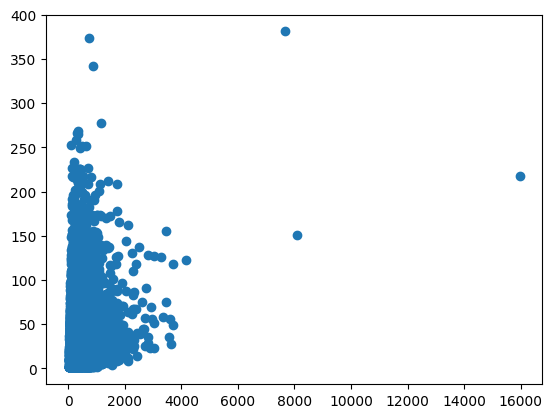

In [114]:
# кол-во лайков / кол-во негативных комментов
plt.scatter(df_vk['likes'], df_vk['num_negatives'])

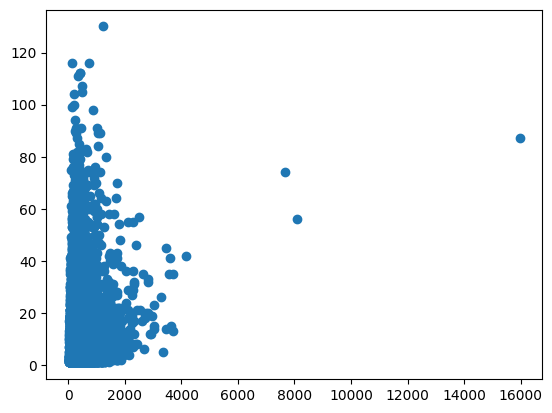

In [115]:
# кол-во лайков / кол-во позитивных комментов
plt.scatter(df_vk['likes'], df_vk['num_positives'])

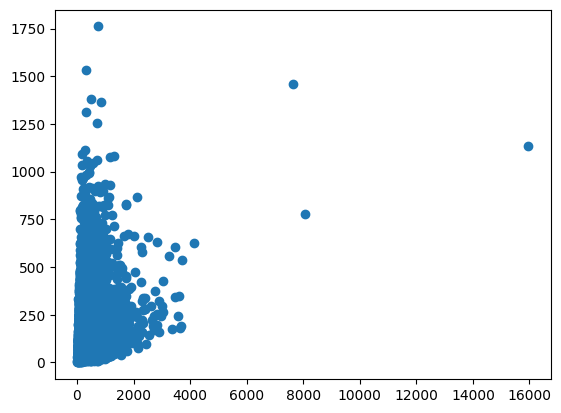

In [116]:
# кол-во лайков / кол-во комментов
plt.scatter(df_vk['likes'], df_vk['comments'])

__[0.2]__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаen, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [117]:
# your code here
# ฅ^•ﻌ•^ฅ
def get_sentiment_score(row):
  a = 1 + row['num_positives']
  b = 1 + row['comments'] - row['num_positives']

  denom = ((a + b) ** 2) * (a + b + 1)
  multipl = np.sqrt(a * b / denom)
  return a / (a + b) - 1.65 * multipl

In [119]:
df_vk['sentiment_scores'] = df_vk.apply(get_sentiment_score, axis=1)

In [123]:
df_vk.sort_values('sentiment_scores', ascending=False)

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,num_positives,num_negatives,sentiment_scores
14189,19965364,/science/20180311/1516126324.html,2018-03-11 20:27:37,"Телескоп ""Хаббл"" сфотографировал сталкивающиес...",369,107,#UNK#,телескоп хаббл сфотографировал сталкивающиеся ...,#UNK#,70.0,3.0,0.576407
14188,19965584,/culture/20180311/1516125774.html,2018-03-11 20:57:56,Юлия Самойлова представит Россию на Евровидени...,418,203,#UNK#,юлия самойлова представит россию на евровидени...,#UNK#,112.0,8.0,0.494041
9521,21544373,https://rsport.ria.ru/russia2018_ourteam/20180...,2018-07-08 16:13:28,Болельщики сборной России подарили Акинфееву б...,921,124,#ЧМ2018,болельщики сборной россии подарили акинфееву б...,чм2018,69.0,10.0,0.482802
10545,21216757,/tourism/20180611/1522532289.html,2018-06-11 19:01:32,Один из самых больших айсбергов на планете мож...,328,63,"Ученые NASA сообщили, что крупнейший айсберг, ...",один из самых больших айсбергов на планете мож...,ученые nasa сообщили что крупнейший айсберг ко...,36.0,2.0,0.468658
9895,21423423,http://ria.ru/society/20180629/1523631104.html,2018-06-29 13:48:42,Обратившаяся к Путину украинка встретилась с с...,405,156,#UNK#,обратившаяся к путину украинка встретилась с с...,#UNK#,79.0,15.0,0.440908
...,...,...,...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,#UNK#,политологи назвали губернаторов которым грозит...,#UNK#,NaN,NaN,NaN
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,#UNK#,захарова рассказала какую книгу подписывал лав...,#UNK#,NaN,NaN,NaN
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,#UNK#,современные люди появились более 300 тысяч лет...,#UNK#,NaN,NaN,NaN
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,#UNK#,в сша ребенок устроил стрельбу,#UNK#,NaN,NaN,NaN


Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.2]__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__

In [ ]:
# your code here
# ٩(⁎❛ᴗ❛⁎)۶


__[0.2 бонусных]__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [ ]:
# your code here
# ヾ(๑╹◡╹)ﾉ